In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 目的

MNISTをresnet18を使って多値分類するコードをベースにして、中で使われている機能や、なぜそんな事をしているかを
軽く深堀りし、pytorchを少しは自由に使えるようになる事を目指します。

## ベースにしたコード

Tonyさん<br>
MNIST with the new PyTorch 1.0.1<br>
https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## tensroとnumpy arrayの違い

tensorは、勾配情報を持つことができる。<br>
バックプロパゲーション後の結果も持てるということ。<br>

https://qiita.com/mathlive/items/241bfb42d852bb801b96#6-tensor%E5%9E%8B%E3%81%AE%E3%82%82%E3%81%861%E3%81%A4%E3%81%AE%E3%83%A1%E3%83%AA%E3%83%83%E3%83%88%E3%81%AEgrad

modelを保存するときなど、勾配情報を持ったtensorをnumpyにするときは、不要な勾配情報を削除するため、detachが必要になってくる。<br>
https://qiita.com/mathlive/items/241bfb42d852bb801b96#6-tensor%E5%9E%8B%E3%81%AE%E3%82%82%E3%81%861%E3%81%A4%E3%81%AE%E3%83%A1%E3%83%AA%E3%83%83%E3%83%88%E3%81%AEgrad


In [ ]:
### => train/testの違い
train_df  = pd.read_csv("../input/digit-recognizer/train.csv") 
test_df = pd.read_csv("../input/digit-recognizer/test.csv") 

### train/testの違い

trainには正解laberがあり、testには無い。
正解labelを使って、正しく正解を導き出せるmodelを作り、作ったmodelとtestのデータを使って、正解を予想するのが、このコンペの目的のため。

In [ ]:
train_df.shape

In [ ]:
train_df.head()

In [ ]:
test_df.shape

In [ ]:
test_df.head()

In [ ]:
random_n = np.random.randint(len(train_df),size=8)
random_n

### => なぜdataframeにmaxを2回も
train_df.max().max()  ##255

### => 255で割っている理由
### => reshapeと-1について
torch.Tensor((train_df.iloc[random_n, 1:].values/255.))

### => 255で割っている理由
### => reshapeと-1について
torch.Tensor((train_df.iloc[random_n, 1:].values/255.).reshape((-1,28,28)))

## 4次元へ変換
### => unsqueezeについて
torch.Tensor((train_df.iloc[random_n, 1:].values/255.).reshape((-1,28,28))).unsqueeze(1)

### => make_grid
grid = make_grid(torch.Tensor((train_df.iloc[random_n, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)

### => transposeについて
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_n, 0].values), sep = ', ')

**

In [ ]:
torch.Tensor((train_df.iloc[random_n, 1:].values/255.).reshape((-1,28,28)))

In [ ]:
torch.Tensor((train_df.iloc[random_n, 1:].values/255.).reshape((-1,28,28)))

In [ ]:
train_df

### なぜdataframeにmaxを2回も

dataframeにmax()を一度実行すると、columnごとにmaxを算出。出てきたものにさらみmax()をすると、columnとごの最大値の中からさらに最大値を見つけることになり、結果dataframe全体の中の最大値を見つける事ができる。

### 255で割っている理由

画像化する為、train_dfを0~1に規格化する為に、255で割っている。<br>
**pytorchのmodelにデータを読ませる場合は、transforms.Normalize処理に規格化が入っているので、255で割る必要なし。**

### reshapeと-1について

https://qiita.com/yosshi4486/items/deb49d5a433a2c8a8ed4


```
source_shape.py
z = np.array([[1, 2, 3, 4],
         [5, 6, 7, 8],
         [9, 10, 11, 12]])
z.shape
(3, 4)
```
-1を渡した場合は、行ベクトルになります。この場合は、列サイズが元の形状から推測されて決定されます。

```
row_vector.py
z.reshape(-1)
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
```

reshape(-1, 2)とすると列数だけが2で決まり、行数は元の形状から推測されて決定されます。

```
reshape.py
z.reshape(-1, 2)
array([[ 1,  2],
   [ 3,  4],
   [ 5,  6],
   [ 7,  8],
   [ 9, 10],
   [11, 12]])
   
   
z.reshape(-1,2,2)
array([[[ 1,  2],
        [ 3,  4]],

       [[ 5,  6],
        [ 7,  8]],

       [[ 9, 10],
        [11, 12]]])

```



### unsqueeze
次元を追加。unsqueeze(1)の1は次元を追加する軸（方向）<br>
nn.Conv2d は サンプル数 x チャネル数 x 高さ x 幅 – nSamples x nChannels x Height x Width の 4D Tensor を取る為、一次元追加している。
もし貴方が単一のサンプルを持つ場合には、fake バッチ次元を付加するために input.unsqueeze(0) を使用してください。
https://pytorch.org/docs/stable/generated/torch.unsqueeze.html

これも次元を増やす方法
df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]

```
>>> x = torch.tensor([1, 2, 3, 4])
>>> torch.unsqueeze(x, 0)
tensor([[ 1,  2,  3,  4]])
>>> torch.unsqueeze(x, 1)
tensor([[ 1],
        [ 2],
        [ 3],
        [ 4]])
```

### make_grid



画像をアレイ表示するためのtorchvision.utils。<br>
https://blog.shikoan.com/torchvision-image-tile/


### numpy.transporse
軸の入れ替え<br>
pytorchでは、画像はnChannels(RGBのこと) x Height x WidthとChannelを先に書くことを期待している。<br>
pytorch向けにreshapeしたため、ここで画像向けに、Height x Width x nChannelsに変換している。

https://deepage.net/features/numpy-transpose.html


## 【補足】次元について

画像は、HightxWidthxChannel(R,G,B)。
pytorchは、N（BatchSize）xCxHxWが必要。
transpose((1,2,0))で、HxWxCへ戻している。

## openCVで読み込んだデータについて触れてみる

opencv(cv2)のimread()で読み込むと、H（高さ） x W（幅） x C色（3）のnumpy arrayだが、
色の順番はBGR（青、緑、赤）。
OpenCVの関数imwrite()はBGRの順番を前提としている。

https://note.nkmk.me/python-opencv-bgr-rgb-cvtcolor/

## Pillowの場合は

Pillowでは色の順番はRGB（赤、緑、青）を前提としている。
OpenCVの関数cvtColor()を使うとRGBやBGR、HSVなど様々な色空間を相互に変換できる。
```
dst = cv2.cvtColor(src, code)
```

引数codeをcv2.COLOR_BGR2RGBとすると、その名前の通りBGRからRGBへの変換となる。

RGBに変換すると、PIL.Imageオブジェクトに変換し保存しても正しい画像として保存される。

```
im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

Image.fromarray(im_rgb).save('data/dst/lena_rgb_pillow.jpg')
```

RGBからBGRへ変換する場合は、引数codeをcv2.COLOR_RGB2BGRとする。<br>
PIL.Imageオブジェクトで読み込んでndarrayに変換後、OpenCVのimwrite()で保存する場合はこちらを使う。

```
im_pillow = np.array(Image.open('data/src/lena.jpg'))

im_bgr = cv2.cvtColor(im_pillow, cv2.COLOR_RGB2BGR)

cv2.imwrite('data/dst/lena_bgr_cv_2.jpg', im_bgr)
```

NumPyの基本機能で実現する場合。

```
im_bgr = cv2.imread('data/src/lena.jpg')

im_rgb = im_bgr[:, :, [2, 1, 0]]
Image.fromarray(im_rgb).save('data/dst/lena_swap.jpg')

im_rgb = im_bgr[:, :, ::-1]
Image.fromarray(im_rgb).save('data/dst/lena_swap_2.jpg')
```



## 【補足】RGBの取り扱いについて

今回はgrayスケールで、RGBではないが、RGBの場合のnumpyの取り扱いはこちら。<br>
https://your-3d.com/python-rgb/



In [ ]:
train_df.iloc[:,1:].mean(axis=1).mean()

In [ ]:
train_df.iloc[:,1:]

# MNIST用Dataset準備

In [ ]:

### => Datasetについて
class MNISTDataset(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, dataframe, 
                 ### => transforms.Composeについて
                 transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.ToTensor(),
                                                 ### => meanとstdの確認
                                                 transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        df = dataframe
        # for MNIST dataset n_pixels should be 784
        self.n_pixels = 784
        
        if len(df.columns) == self.n_pixels:
            # test data　次の方法で次元を増やしている。
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Datasetについて
datasetを継承して使う。<br>
[torch.data.dataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset)

以下3つが必須。
* __init__()
* __getitem__()
* __len__()

A more detailed [DATA LOADING AND PROCESSING TUTORIAL](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) on PyTorch official website.


今回はcsvからdatasetを作っているが、MNISTはもともとdatasetが準備されている。


### Datasetとdataloaderの関係

こちらのサイトが詳しい<br>
https://qiita.com/mathlive/items/2a512831878b8018db02

https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

#### Dataset

```
trainset = torchvision.datasets.MNIST(root = 'path', train = True, download = True, transform = trans)
```

中身は、


```
print(trainset[0])

------'''以下出力結果'''--------
(tensor([data内容]), そのdataに対応する正解label)
```


#### dataloader

```
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 100, shuffle = True, num_workers = 2)
```
データsetをtrainingのために、分割したりbatch化したりしている。<br>
DataLoaderは配列ではなくiteratorな為、次の方法で中身を見る。

```
for data,label in trainloader:
    break
print(data)
print(label)

------'''以下出力結果'''--------
tensor([[data1], [data2],..., [data100]])
tensor([label1, label2,..., label100])
```

やっていることはこちら。

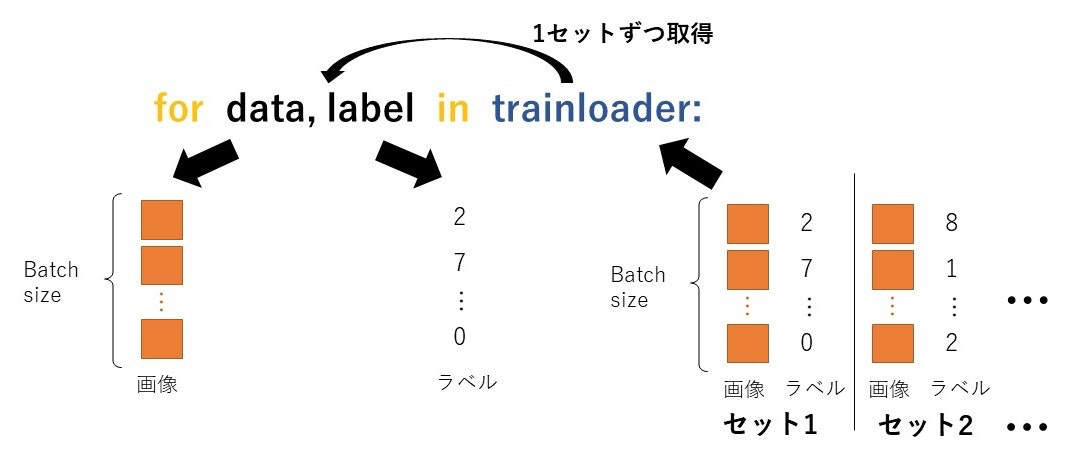

### transforms.Composeについて

torchvision.transforms.Composeは引数で渡されたlist型の[~~,~~,...]というのを先頭から順に実行していくものである。<br>
そのためlist内の前処理の順番には十分注意する。<br>
Compseので行う処理の中に、データの水増しがある。

### データ水増しの種類について


代表的な処理として、以下があげられる。


* 回転
transforms.RandomRotation で変換できます。degrees 引数で回転の度合いを指定します。
```
transform = transforms.RandomRotation(degrees=30)
```

* 水平移動

transforms.RandomAffine() で変換できます。translate 引数で縦横方向への移動の幅の指定ができます。
例えば 32 ピクセルの正方形の画像で、translate=(0.5, 0) とした場合、縦方向に -16 ~ 16 の幅でランダムに水平移動します

```
transform = transforms.RandomAffine(degrees=0, translate=(0.5, 0.5))
```

* せん断

transform = transforms.RandomAffine(degrees=0, translate=(0, 0), shear=(0, 30))

```
transform = transforms.RandomAffine(degrees=0, translate=(0, 0), shear=(0, 30))

```

* 拡大

transform = transforms.RandomCrop((16, 16))

```
transforms.RandomCrop で変換します。引数にはクロップする縦横の画素数を指定します。
```

* 水平反転

transforms.RandomHorizontalFlip で変換します。引数 p には、反転を起こす確率を与えます。
もしも 1 とすると、100% 水平に反転するということを表します。

```
transform = transforms.RandomHorizontalFlip(p=1) 
```

* 垂直反転

transforms.RandomVerticalFlip で変換します。引数 p には、反転を起こす確率を与えます。
もしも 1 とすると、100% 垂直に反転するということを表します。

```
transform = transforms.RandomVerticalFlip(p=1) 
```


### 補足

回転や水平移動、せん断で生じる空白箇所は、デフォルトでは輝度が 0（黒色）で埋められます。
空白箇所を任意の色で塗りつぶしたい場合は、fillcolor 引数で指定します。カラー画像の場合、RGB  の輝度をタプルで与えます。

```
transform = transforms.RandomAffine(degrees=0, translate=(0.5, 0.5), fillcolor=(100, 100, 100))
```

### meanとstdの確認

https://deeplizard.com/learn/video/lu7TCu7HeYc


次の方法で、mean stdを調べることが可能。
ひとまず、0.5と0.5にしておく

```
loader = DataLoader(dataset=train_dataset, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

(tensor(0.2860), tensor(0.3530))
```


# MNIST用Resnet準備

In [ ]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

### => MNIST用にResNetを修正
class MNISTResNet(ResNet):
    def __init__(self):
        #super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        super().__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        # Conv2dのoutput_channel 64 はデフォルト

        ### => conv1のconv2dについて
        ### => kernelについて
        ### => strideについて
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)
        #self.fc    = nn.Linear(784 * 1, 10)

model = MNISTResNet()
print(model)

### MNIST用にResNetを修正

デフォルトのResNetの入力チャンネル数(RGBの部分)と出力クラス数を、MNIST用に調整する必要がある。
入力ベクタサイズはたしか自動調整。
以下はその説明。


### Modify the official ResNet for MNIST

The official ResNet model is designed for the classification task on RGB image dataset, e.g. ImagNet. The main difference between ImageNet and MNIST is the following two points:

| Input Image  |      ImageNet      |       MNIST       |
| :---------:  | :----------------: | :---------------: |
|  Channels    |      3    |     1       |
| Resolution   | 224 x 224  | 28 x 28  |
| Classes  | 1000 | 10 |
So we should better do some modifications on the original networks to adapt for MNIST dataset. Specifically, add the following modifications:

* **Change the first convolutional layer to accept single channel input**
* **Change the stride of the first convolutional layer from 2 to 1**
* **Change the last fc layer's output features from 1000 to 10**

Before we start, in order to know which part of the code to modify, let's take a look how we get a model when calling the `torchvision.models.resnet18()` function.

Here is the source code of `torchvision.models.resnet18()`. When we construct the ResNet18 architecture, we are running the following procedure.

### conv1のconv2dについて

参考URL<br>
https://blog.shikoan.com/pytorch-convtranspose2d/

エンコーダーのConv2Dでダウンサンプリング
まず前提として、MaxPoolingなどのPoolingを使わなくても畳み込み（Conv2D）だけでダウンサンプリングはできます。GANで使われる手法ですが、CNNでも使えます。例えばMNISTで考えましょう。

入力：(-1, 1, 28, 28)＋kernel=3の畳み込み
出力：(-1, 32, 14, 14)


どういう処理かというと、モノクロ（チャンネル数1）の28×28の画像を、32チャンネルの3×3の畳み込みを通して、14×14にダウンサンプリングするというものです。これを1つのConv2Dで定義するにはどうしたらよいでしょうか？答えはこうです。

```
import torch.nn as nn
nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
```
これはわかりやすいと思います。PyTorchのpaddingは両側に付与するピクセル数、つまりpadding=1なら左右に1ピクセルずつ入れるということに注意してください。公式ドキュメントによると、出力の解像度の計算式は、

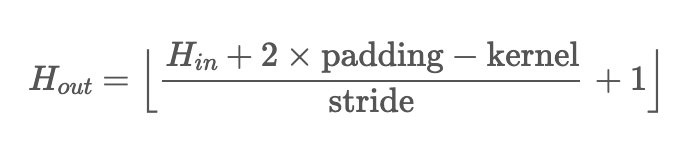

で表されます（ドキュメントにはdilationがありますが、自分は使ったことないので省略しています）。上の式の場合、分母は「28+2×1-3 = 27」、strideの2で割り1を足すと14.5、小数点以下を切り捨てて「14」、ちゃんと正しく計算できていますね。

計算中に端数ができていることについてですが、（エンコーダー側の）CNNの場合はkernelを奇数とすることが普通です。奇数にすると中心のピクセルが生まれ、畳込みの計算が有効に機能しやすいと言われています。

### kernelについて

フィルタとも言われる。

1_qLvvyAA_IbXLff5mAZYbiA.png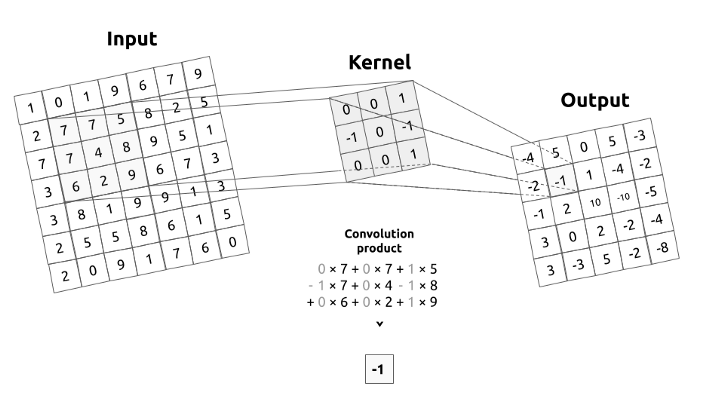

### strideについて

picture_pc_0e10907a9e23465579518ac853c34a4b.png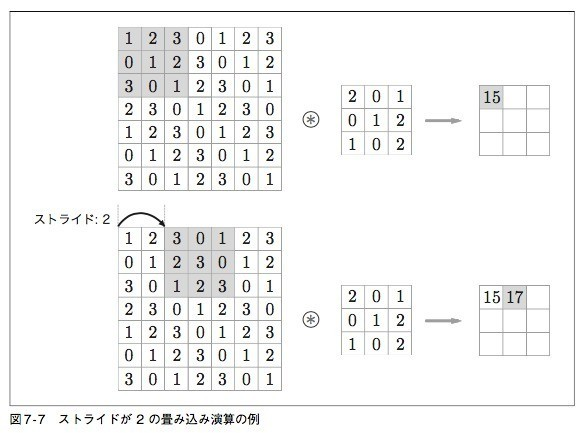

### 【補足] Resnet以外のmodelについて

First, let's take a look at all available models in the torchvision package.

The models subpackage contains definitions for the following model architectures:
- [AlexNet](https://arxiv.org/abs/1404.5997)
- [VGG](https://arxiv.org/abs/1409.1556)
- [ResNet](https://arxiv.org/abs/1512.03385)
- [SqueezeNet](https://arxiv.org/abs/1602.07360)
- [DenseNet](https://arxiv.org/abs/1608.06993)
- [Inception](https://arxiv.org/abs/1512.00567) v3
- [GoogLeNet](https://arxiv.org/abs/1409.4842)
- [ShuffleNet](https://arxiv.org/abs/1807.11164) v2

You can construct a model with random weights by calling its constructor:
```
>>> resnet18 = models.resnet18()
```

If you want to look closer to the source code of every model in torchvision package. You can find it on its official webpage or github repository. For example, the code of ResNet model is showed in the following page:
- [torchvision.models.resnet](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html)

### 【補足】学習済みモデルのdownloadについて

pytorchのソースに次のようにあるので、自動でダウンロードされる。

```
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}
```

# train用関数

In [ ]:
### => trainについて
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    loss_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # if GPU available, move data and target to GPU
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)
        #loss_train += criterion(output, target).data.item()
        
        # TODO:
        # 1. add batch metric (acc1, acc5)
        # 2. add average metric top1=sum(acc1)/batch_idx, top5 = sum(acc5)/batch_idx
        
        # backward and update model
        ### => zero_grad()
        optimizer.zero_grad()
        ### => loss.backward()
        loss.backward()
        ### => optimizer.step()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))
    
    #loss_train /= len(val_loader.dataset)
    #history['train_loss'].append(loss_train)

### Trainについて

optimizer.zero_grad()
loss.backward()
optimizer.step()
を行いながら、正解とモデル出力の差が小さくなるようにモデルを更新していっている。


参考URL<br>
https://ohke.hateblo.jp/entry/2019/12/07/230000

### zero_grad()
backwardメソッドでは勾配が累積されることに注意です。ミニバッチなどを考慮してこのようになっているのですが、以下のように3回続けてbackwardを呼び出すと勾配も3倍になります。
このためパラメータの更新が終わった後に勾配をゼロクリアする必要があります。optimパッケージのzero_gradメソッドでやっていることはこれと同じです。
```
for i in range(3):
    y_p = param_w * x + param_b
    loss = torch.mean((y_p - y)**2)
    loss.backward()
    print(param_w.grad, param_b.grad)

# tensor([-33.8909]) tensor([-20.4400])
# tensor([-67.7818]) tensor([-40.8801])
# tensor([-101.6727]) tensor([-61.3201])

for i in range(3):
    if param_w.grad: param_w.grad.zero_()
    if param_b.grad: param_b.grad.zero_()
    y_p = param_w * x + param_b
    loss = torch.mean((y_p - y)**2)
    loss.backward()
    print(param_w.grad, param_b.grad)

# tensor([-33.8909]) tensor([-20.4400])
# tensor([-33.8909]) tensor([-20.4400])
# tensor([-33.8909]) tensor([-20.4400])
```

https://ohke.hateblo.jp/entry/2019/12/07/230000



### loss.backward()

下図の逆伝搬がbackword()<br>
更新する量は、勾配xlearning_rate

 <img src="https://thinkit.co.jp/sites/default/files/article_node/AI_math03_01.png" width="600">


### opitimizer.step()

計算済みのlossの勾配を使って、modelを更新します。<br>


gradプロパティに適当な学習率をかけてパラメータを更新すれば、簡単な勾配降下法を実装できることが予想できます。optimパッケージのstepメソッドはまさにこれをやってます。

以下で、optimizer.step()と同じ事を書いてみる。


param_wとparam_bはフォワードにて既に計算グラフ内に組み込まれていますので、以下のようにナイーブに計算するとおかしくなります。
```
learning_rate = 0.01

param_w = param_w - param_w.grad * learning_rate
param_b = param_b - param_b.grad * learning_rate

print(param_w, param_b)

```

Tensorのdetachメソッドで計算グラフから切り離すことができます。

さらに勾配を再計算する場合は、忘れずrequires_gradプロパティをTrueにセットしてください
```
learning_rate = 0.01

param_w = (param_w - param_w.grad * learning_rate).detach().requires_grad_()
param_b = (param_b - param_b.grad * learning_rate).detach().requires_grad_()

print(param_w, param_b)
```

直にoptimizer(SGD)の勾配更新を書くと次の通り

```
param_w = torch.tensor([1.0], requires_grad=True)
param_b = torch.tensor([0.0], requires_grad=True)

epochs = 300
learning_rate = 0.01

for epoch in range(1, epochs + 1):
    y_p = param_w * x + param_b
    loss = torch.mean((y_p - y)**2)
    
    loss.backward()
    
    param_w = (param_w - param_w.grad * learning_rate).detach().requires_grad_()
    param_b = (param_b - param_b.grad * learning_rate).detach().requires_grad_()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss}, param_w={float(param_w)}, param_b={float(param_b)}")

# Epoch 10: loss=52.31643295288086, param_w=3.4754106998443604, param_b=1.6848385334014893
# Epoch 20: loss=23.30514144897461, param_w=4.616385459899902, param_b=2.8110599517822266
# ...
# Epoch 300: loss=0.5062416791915894, param_w=4.625252723693848, param_b=7.377382755279541
```


opitimizer.step()を使うと、

```
# ... (省略) ...

optimizer = optim.SGD([param_w, param_b], lr=learning_rate)

for epoch in range(1, epochs + 1):
    y_p = param_w * x + param_b
    loss = torch.mean((y_p - y)**2)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss}, param_w={float(param_w)}, param_b={float(param_b)}")
        
# Epoch 10: loss=52.31643295288086, param_w=3.4754106998443604, param_b=1.6848385334014893
# Epoch 20: loss=23.30513572692871, param_w=4.616385459899902, param_b=2.8110601902008057
# ...
# Epoch 300: loss=0.5062416791915894, param_w=4.625252723693848, param_b=7.377382755279541
```


## detachについて

detach()はTensor型から勾配情報を抜いたものを取得する.<br>
https://qiita.com/mathlive/items/241bfb42d852bb801b96

# Validate用関数

In [ ]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    
    for _, (data, target) in enumerate(val_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        ### => modelにdataを入力したとき
        output = model(data)
        
        ### => validate時のlossについて
        loss += criterion(output, target).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        
        
    loss /= len(val_loader.dataset)
    #history['val_loss'].append(loss)
        
    print('\nOn Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_loader.dataset),
        100.0 * float(correct) / len(val_loader.dataset)))


### modelにdataを入力したとき
resnetの継承もとのnn.Moduleを読むと、forowrdが呼ばれている。<br>
forward実行時に、networkを形作っている<br>
https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.eval

forwordが呼ばれるとすると、resnetの出力が帰ってきている。なので、サイズ10のベクタ。<br>
https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html


### validate時のlossについて

trainと違って、1epochで読み込みデータの平均lossを計算する為、loss += criterionになっている。



# 画像処理設定

In [ ]:
train_transforms = transforms.Compose(
    [transforms.ToPILImage(),
### => RandAffineについて
#     RandAffine,
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

val_test_transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))])

### RandAffineについて

手書き文字なので、傾いた文字は存在しているはず。
傾けた画像を作って学習したほうが効果が高いと予想されるが、今回はTAT優先でとりあえず今はoff

# training向けの設定

In [ ]:
# example config, use the comments to get higher accuracy
total_epoches = 20 # 50
step_size = 5     # 10
base_lr = 0.01    # 0.01
batch_size = 64


### => optimizerについて
optimizer = optim.Adam(model.parameters(), lr=base_lr)
### => nn.CrossEntropyLossについて
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

### optimizerについて

pytorchのoptimizer一覧<br>
https://rightcode.co.jp/blog/information-technology/torch-optim-optimizer-compare-and-verify-update-process-and-performance-of-optimization-methods


### nn.CrossEntropyLossについて

答えとモデルの出力とのズレの評価方法の一つ。

 <img src="https://www.programmersought.com/images/567/aaf7fc897c71a19520cdf8a935e06c87.JPEG" width="500">

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html



### lr_scheduler

learningレートをスケジュールする機能。<br>
エポックがstep size進むごとに、learning rateにgammaを掛け算する。<br>
https://wonderfuru.com/scheduler/

# データ分割用関数

In [ ]:
def split_dataframe(dataframe=None, fraction=0.9, rand_seed=1):
    df_1 = dataframe.sample(frac=fraction, random_state=rand_seed)
    df_2 = dataframe.drop(df_1.index)
    return df_1, df_2

# Training実行

In [ ]:
#history = {
#    'train_loss': [],
#    'val_loss': [],
#    'test_acc': [],
#}


for epoch in range(total_epoches):
    print("\nTrain Epoch {}: lr = {}".format(epoch, exp_lr_scheduler.get_lr()[0]))

    train_df_new, val_df = split_dataframe(dataframe=train_df, fraction=0.9, rand_seed=epoch)
    
    ## オリジナルではget_datasetでMNISTDatasetをwrappingしているが、わかりにくいので外す。
    #train_dataset = get_dataset(train_df_new, transform=train_transforms)
    #val_dataset = get_dataset(val_df, transform=val_test_transforms)
    train_dataset = MNISTDataset(train_df_new, transform=train_transforms)
    val_dataset = MNISTDataset(val_df, transform=val_test_transforms)
    
    
    # CIFAR10の場合、次。torchvisionにデータが準備されているのでそれを利用するだけ。
    #train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    #test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

    
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size, shuffle=False)
    
    

    train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
    validate(val_loader=val_loader, model=model, criterion=criterion)
    exp_lr_scheduler.step()

#plt.figure()
#plt.plot( range(1, total_epoches+1), history['train_loss'], label='train_loss' )
#plt.plot( range(1, total_epoches+1), history['val_loss'], label='val_loss' )
#plt.show()

# Prediction on Test Set

In [ ]:
def prediciton(test_loader, model):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

## output.cpu().dataについて考察

x , x.data , x.cpu().data ,違いが見えない。。。

In [ ]:
x = torch.tensor(2.5)
x
x.data
x.cpu().data

In [ ]:
test_batch_size = 64
## オリジナルではget_datasetでMNISTDatasetをwrappingしているが、わかりにくいので外す。
#test_dataset = get_dataset(test_df, transform=val_test_transforms)
test_dataset = MNISTDataset(test_df, transform=val_test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size, shuffle=False)

# tensor prediction
test_pred = prediciton(test_loader, model)

# tensor -> numpy.ndarray -> pandas.DataFrame
test_pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1), test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# show part of prediction dataframe
print(test_pred_df.head())

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link and click to download
create_download_link(test_pred_df, filename="submission.csv")

In [ ]:
test_pred_df.to_csv('submission.csv', index=False)

## 参考URL

cnn-resnet18-mnist<br>
https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb

NNをpytorchを使って作成<br>
https://qiita.com/fukuit/items/215ef75113d97560e599

transformマニュアル<br>
https://pytorch.org/docs/stable/torchvision/transforms.html

pyTorchのtransforms,Datasets,Dataloaderの説明<br>
https://qiita.com/mathlive/items/2a512831878b8018db02

torchvisionのtransforms<br>
https://tasotasoso.hatenablog.com/entry/2020/01/12/184130?utm_source=feed

chumajinさんTraining<br>
https://www.kaggle.com/chumajin/day3-inference-resnet18

Basicなpytorch<br>
https://www.kaggle.com/cauthur/basic-deep-learning-with-pytorch

resnetのソース<br>
https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html

図でまとめるCNN(ゼロから作るDeep learningがもとネタ。pythorchで載っている。）<br>
https://note.com/ryuwryyy/n/nfd0b8ff862aa

pytorchチートシート<br>
https://qiita.com/dokkozo/items/e173acded17a142e6d02

pytorch tensorチートシート<br>
https://qiita.com/dokkozo/items/e173acded17a142e6d02

pytorchについて結構まとまっている<br>
https://qiita.com/miyamotok0105/items/1fd1d5c3532b174720cd

pytorchについて結構まとまっている2<br>
https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

PyTorch transforms/Dataset/DataLoaderの基本動作を確認する<br>
https://qiita.com/takurooo/items/e4c91c5d78059f92e76d

pytorchのoptimizer一覧<br>
https://rightcode.co.jp/blog/information-technology/torch-optim-optimizer-compare-and-verify-update-process-and-performance-of-optimization-methods


PyTorchは誤差逆伝播とパラメータ更新をどうやって行っているのか？<br>
https://ohke.hateblo.jp/entry/2019/12/07/230000


## resnetを書いているもの

CNNの代表的なモデルResNetの実装とそれを用いた画像認識<br>
https://aizine.ai/cnn-0801/

ResNet (Residual Network) の実装<br>
https://www.bigdata-navi.com/aidrops/2611/

ResNetをいろんな機械学習ライブラリで実装してみた~TensorFlow編~<br>
https://qiita.com/gucchi0403/items/097d83f0e8a6091c1240



## 補足

__getitem__の挙動<br>
https://pheromone.hatenablog.com/entry/20100829/1283088398

__getitem__に与える引数やスライス<br>
https://qiita.com/gyu-don/items/bde192b129a7b1b8c532

python2と3のsuperの使い方の違い<br>
https://www.lifewithpython.com/2014/01/python-super-function.html

ResNet18でCIAFR10を画像分類<br>
https://testpy.hatenablog.com/entry/2020/01/12/171347

pytorchでCNNのlossが毎回変わる問題の対処法 (on gpu)<br>
https://qiita.com/chat-flip/items/c2e983b7f30ef10b91f6

pytorchでCNNのlossが毎回変わる問題の対処法 (on cpu)<br>
https://qiita.com/chat-flip/items/4c0b71a7c0f5f6ae437f


## Convolutional neural networkについてわかりやすい記事

畳み込みニューラルネットワークの仕組み
https://postd.cc/how-do-convolutional-neural-networks-work/

Convolutional Neural Networkとは何なのか
https://qiita.com/icoxfog417/items/5fd55fad152231d706c2
